<a href="https://colab.research.google.com/github/meriem-belkacemi/Machine-Learning-Notebooks/blob/main/Regularisation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Ce TP a été réalisé par :

*   BELKACEMI Meriem
*   LABRI Ahlem
*   MAYOUF Lotfi









# Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un profuit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données.

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (118, 3)  y  (118, 1)


# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités



---



Un polynome de degrès 6 à 2 variables s'écrit de la façon suivante : P(x1,x2) = ∑ (x1^ * x2^j), avec (i + j) <= 6. En appliquant cette formule, on obtient :


*   Pour i = 0, on a un terme de la forme x2^j. On peut avoir j = 0, 1, 2, 3, 4, 5, 6 ce qui donne 7 termes.
*   Pour i = 1, on a un terme de la forme x1 * x2^j. On peut avoir j = 0, 1, 2, 3, 4, 5 ce qui donne 6 termes.
*   Pour i = 2, on a un terme de la forme x1^2 * x2^j. On peut avoir j = 0, 1, 2, 3, 4 ce qui donne 5 termes.
*   Pour i = 3, on a un terme de la forme x1^3 * x2^j. On peut avoir j = 0, 1, 2, 3 ce qui donne 4 termes.
*   Pour i = 4, on a un terme de la forme x1^4 * x2^j. On peut avoir j = 0, 1, 2 ce qui donne 3 termes.
*   Pour i = 5, on a un terme de la forme x1^5 * x2^j. On peut avoir j = 0, 1 ce qui donne 2 termes.
*   Pour i = 6, on a un terme de la forme x1^6 * x2^j. On peut avoir j = 0 ce qui donne 1 terme.

En additionnant tous ces termes, on obtient un total de 7+6+5+4+3+2+1 = 28 termes différents dans un polynôme de degré 6 à deux variables.


---

De façon plus générale, on peut obtenir le nombre de caractéristiques dans ce polynome par la formule suivante :

\begin{align}
 &\sum_{i=0}^n (i+1) = n+1+ \frac{n(n+1)}{2} \\[1em]
\end{align}
Pour n=6, la somme est égale à 28.

In [ ]:
def mapping(X):

    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j))
            k=k+1
    return outX


In [ ]:
X=mapping(X)
X.shape

(118, 28)

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))


In [ ]:
k=Sigmoid(-10)
k

4.5397868702434395e-05

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [ ]:
def computeCostReg(X, y, theta, lambda_):
    m = len(y)

    # Calcul de la sortie de la fonction sigmoid pour chaque exemple
    # La multiplication matricielle X @ theta calcule le produit matriciel de X et theta,
    # qui permet de faire la somme pondérée de chaque caractéristique de l'entrée.
    h = Sigmoid(X @ theta)

    # Vérification et correction des problèmes de débordement pour éviter les erreurs de calcul
    # np.clip(h, eps, 1 - eps) s'assure que les valeurs de h restent dans l'intervalle [eps, 1 - eps]
    eps = 1e-15
    h = np.clip(h, eps, 1 - eps)

    # Calcul de la pénalité de régularisation pour les paramètres theta à l'exception de theta[0]
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))

    # Calcul du coût de la régression logistique avec régularisation
    J = (1 / m) * (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) + reg_term

    return J


2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [ ]:
def gradientDescent(X, y, theta, alpha, iterations,lambda_, epsilon=None, ):

    m = len(y)
    # Historique des coûts pour chaque itération
    J_history = np.zeros((iterations, 1))
    # Historique des gradients pour chaque itération
    gradients = np.zeros((iterations, len(theta)))
    # Si epsilon n'est pas spécifié, utiliser une valeur par défaut
    if epsilon is None:
        epsilon = 1e-9

    for iter in range(iterations):
        # Prédiction avec les paramètres theta actuels
        h = Sigmoid(X @ theta)
        # Calcul de l'erreur de prédiction
        error = h - y
        # Calcul du gradient régularisé
        grad = (1 / m) * (X.T @ error) + (lambda_ / m) * theta
        # Le terme de régularisation ne s'applique pas au premier paramètre theta0
        grad[0] -= (lambda_ / m) * theta[0]

        # Mise à jour des paramètres theta
        theta = theta - alpha * grad
        # Calcul du coût avec les nouveaux paramètres
        J_history[iter] = computeCostReg(X, y, theta, lambda_)
        # Stockage du gradient actuel
        gradients[iter, :] = grad.flatten()

        # Arrêt de l'entraînement si la moyenne des gradients est inférieure à epsilon
        if iter > 0 and np.absolute(gradients[iter, :].mean()) < epsilon:
            break

    # Retourne les paramètres finaux, l'historique des coûts et des gradients
    return theta, J_history[:iter+1], gradients[:iter+1, :]


In [ ]:
def plot_cost_gradient(costs, gradients):
    # Définition d'une figure avec 1 ligne et 2 colonnes de graphes
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    # Tracer la courbe du coût en fonction du nombre d'itérations
    plt.plot(range(costs.shape[0]), costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')

    # Ajout du titre du graphe
    plt.title("Courbe de coût")

    # Tracer le gradient de chaque paramètre en fonction du nombre d'itérations
    plt.subplot(1, 2, 2)
    for i in range(gradients.shape[1]):
        plt.plot(range(gradients.shape[0]), gradients[:, i])

    # Ajout des étiquettes de l'axe x et y et le titre du graphe
    plt.xlabel('iterations')
    plt.ylabel('gardient')
    plt.title("Courbe de gradient")

# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [ ]:
n=X.shape[1]
theta = np.zeros((n, 1))

Calculer le cout initial

In [ ]:
initialCost=computeCostReg(X, y, theta,lambda_=1)
print(initialCost)

[[0.69314718]]


Appel des la fonction de calcul du gradient

In [ ]:
# paramètres
iterations = 20000
alpha = 0.01

# paramètre de regression
lambda_ = 1

# Appel
theta, costs, gradients = gradientDescent(X, y, theta, alpha, iterations,lambda_)

Traçage de la fonction du coût

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

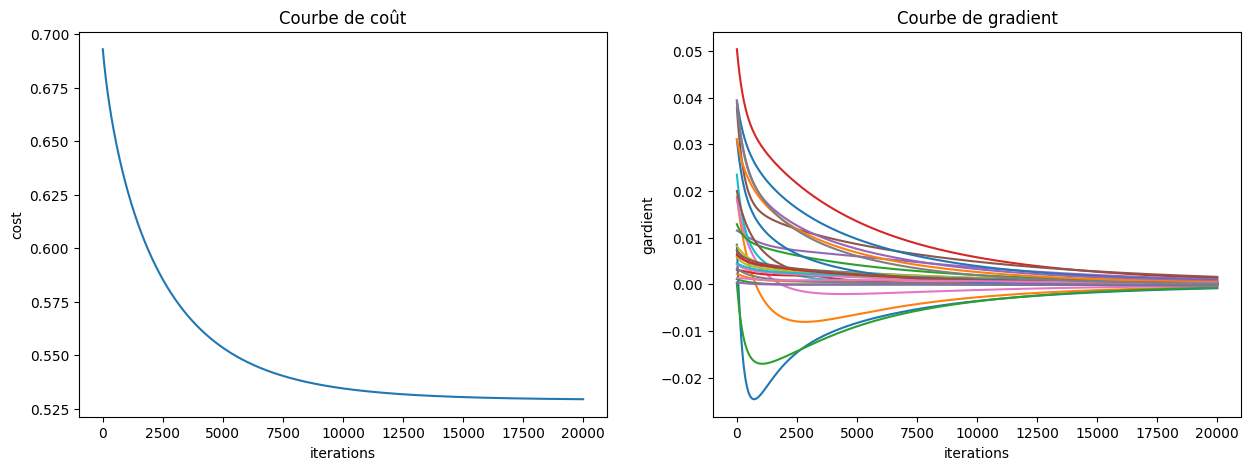

In [ ]:
plot_cost_gradient(costs, gradients)

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [ ]:
def drawCircle(X, y, theta,title=None):

    # Trouver les valeurs minimales et maximales de nos features
    x_min, x_max = X[:, 1].min(), X[:, 1].max()
    y_min, y_max = X[:, 2].min(), X[:, 2].max()

    # Créer une grille de 100x100 points entre les valeurs minimales et maximales de x et y
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Concaténer les points de la grille en une matrice de taille (nombre_de_points, 2)
    x_in = np.c_[x1.ravel(), x2.ravel()]

    # Calculer les prédictions pour chaque point de la grille
    y_pred = (mapping(np.c_[np.ones(x1.size), x_in]) @ theta).reshape(x1.shape)

    # Afficher la frontière de décision
    plt.contour(x1, x2, y_pred, levels=[0])

    # Afficher les points de la classe 1 en rouge et 0 en bleu
    plt.scatter(X[np.where(y == 1), 1], X[np.where(y == 1), 2], label="y=1", marker='o')
    plt.scatter(X[np.where(y == 0), 1], X[np.where(y == 0), 2], label="y=0", marker='x')

    plt.title(title)
    plt.xlabel('x 1')
    plt.ylabel('x 2')

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [ ]:
def predict(X):
    y_pred = np.zeros((X.shape[0], 1))
    y_pred[np.where(Sigmoid(X @ theta) > 0.5)] = 1
    return y_pred


# Affichage
Graphe representant les acceptations selon les caracteristiques

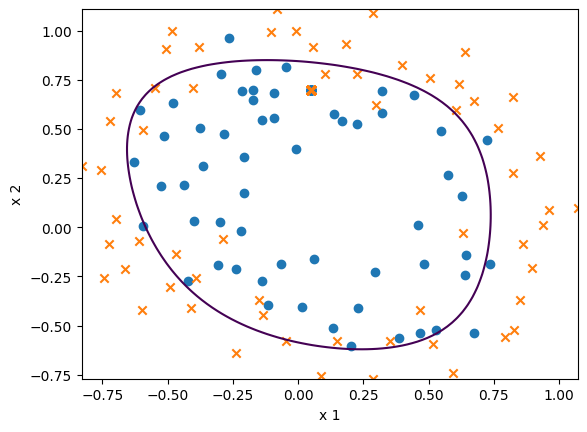

In [ ]:
drawCircle(X,y,theta)

Traçage du coût en fonction de theta0 et theta1

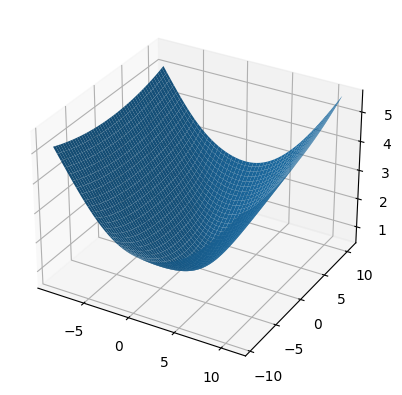

In [ ]:
# Création de grilles pour les valeurs de theta_0 et theta_1
theta_0_range, theta_1_range = np.meshgrid(np.arange(theta[0] - 10, theta[0] + 10, 0.1),
                                           np.arange(theta[1] - 10, theta[1] + 10, 0.1))

# Création d'une matrice 4D avec theta_0 et theta_1 dans les dimensions 0 et 1, respectivement
theta_mesh = np.expand_dims(np.stack((theta_0_range, theta_1_range), axis=-1), axis=3)

# Calcul de la fonction de perte pour chaque paire de theta_0 et theta_1 dans theta_mesh
loss = np.asarray(
    [
        [computeCostReg(X, y, np.concatenate((theta_mesh[i, j], theta[2:]), axis=0), lambda_)[0]
             for j in range(theta_mesh.shape[1])
        ]
        for i in range(theta_mesh.shape[0])
    ]
)


# Création d'une figure 3D
fig = plt.figure()

# Ajout d'un sous-plot 3D
ax = fig.add_subplot(111, projection='3d')

# Traçage de la surface de la fonction de perte en utilisant les valeurs de theta_0_range, theta_1_range et loss
ax.plot_surface(theta_0_range, theta_1_range, np.squeeze(loss))

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X)
prcision = np.mean(y==y_pred)*100
prcision

83.05084745762711

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
from sklearn.linear_model import LogisticRegression


def compare(X , y , theta):

    # Création d'un objet LogisticRegression et spécification du paramètre de rgularisation penalty='l2'
    sklearn_model = LogisticRegression(penalty='l2')

    # Entraînement du modèle sur les données X et les étiquettes y
    sklearn_model.fit(X[: , 1:] ,  y)

    # Extraction des paramètres estimés du modèle entraîné avec sklearn
    sklearn_theta = np.zeros(theta.shape)
    sklearn_theta[0 , 0] = sklearn_model.intercept_[0]
    sklearn_theta [1 : , 0] = sklearn_model.coef_.reshape(-1 , 1)[:,0]

    # Affichage des paramètres estimés pour les deux modèles
    print("sklearn model theta : " , sklearn_theta)
    print("our model theta  : " , theta)

    # Calcul et affichage de l'erreur (coût) pour les deux modèles
    print("\nsklearn error (cost)    :" , computeCostReg(X , y , sklearn_theta,0))
    print("our model error (cost)  :" , computeCostReg(X , y , theta,0))

    # Calcul et affichage de la précision pour les deux modèles
    print("\nsklearn precision : ",np.mean(np.mean(y.reshape(-1,)==sklearn_model.predict(X[:, 1:]))*100))
    print("our model precision : ",np.mean(y==predict(X))*100)

    # Affichage des graphiques pour les deux modèles
    plt.figure(figsize=(15, 7))

    plt.subplot(1,2,1)
    drawCircle(X , y , sklearn_theta , "Sklearn model")

    plt.subplot(1,2,2)
    drawCircle(X , y , theta , "Our model")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn model theta :  [[ 1.27271075]
 [ 0.62536719]
 [ 1.18095854]
 [-2.01961804]
 [-0.91752388]
 [-1.43170395]
 [ 0.12391867]
 [-0.36536954]
 [-0.35715555]
 [-0.17501434]
 [-1.45827831]
 [-0.05112356]
 [-0.61575808]
 [-0.27472128]
 [-1.19276292]
 [-0.24241519]
 [-0.20587922]
 [-0.0448395 ]
 [-0.27780311]
 [-0.29535733]
 [-0.45625452]
 [-1.04347339]
 [ 0.02770608]
 [-0.29252353]
 [ 0.01550105]
 [-0.32746466]
 [-0.1439423 ]
 [-0.92460358]]
our model theta  :  [[ 1.20521812]
 [ 0.58259575]
 [ 1.13134301]
 [-1.92013423]
 [-0.83056988]
 [-1.28496215]
 [ 0.10189608]
 [-0.34252552]
 [-0.34135251]
 [-0.18125994]
 [-1.40956855]
 [-0.06604411]
 [-0.58032641]
 [-0.24610054]
 [-1.14672102]
 [-0.24322098]
 [-0.20113273]
 [-0.05872165]
 [-0.25849166]
 [-0.27167027]
 [-0.49102021]
 [-1.01576224]
 [ 0.0110959 ]
 [-0.28016002]
 [ 0.00479444]
 [-0.309752  ]
 [-0.12602254]
 [-0.94014043]]

sklearn error (cost)    : [[0.46246132]]
our model error (cost)  : [[0.46912214]]

sklearn precision :  83.0508474

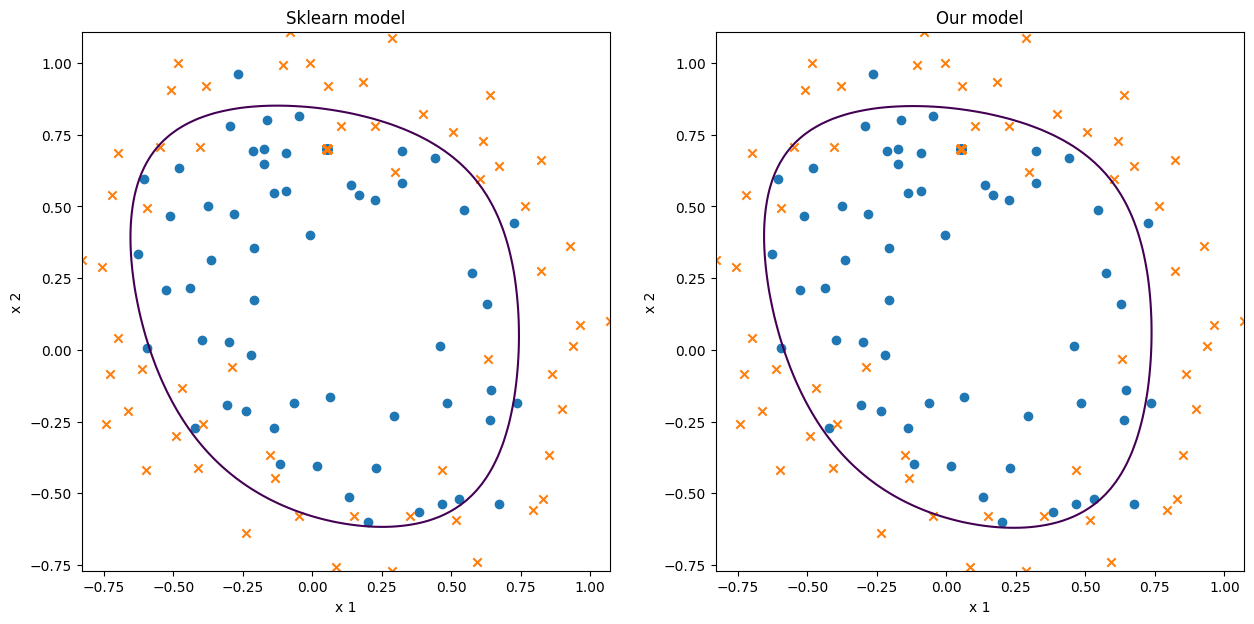

In [ ]:
compare(X , y , theta)

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

Pour renforcer notre apprentissage nous avons utilisé cross-validation avec grid-search pour séléctionner la meilleur valeur de lambda , nous avons appliqué ces techniques sur le model de sklearn parceque c'est plus simple a appliquer et puis nous allons utiliser la meilleur valeur de lambda avec notre modèle


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les valeurs de paramètre de régularisation (lambda) à tester à travers la recherche en grille (grid search)
param_grid = {'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1]}

# Créer une instance de la classe LogisticRegression
logreg = LogisticRegression()

# Créer un objet GridSearchCV pour faire la recherche en grille et ajuster les hyperparamètres du modèle sur les données d'apprentissage
# Ici, on utilise la validation croisée à 10 plis (10-fold cross-validation) pour évaluer chaque combinaison de paramètres
grid_search = GridSearchCV(logreg, param_grid, cv=10)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1]})

In [ ]:
print("Best lambda:", grid_search.best_params_['C'])

Best lambda: 0.6


# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 01 Avril 2022 à 22h


In [ ]:
# bonne chance